<a href="https://colab.research.google.com/github/05satyam/AI-ML/blob/main/Graph_Based_Retrieval_Augmented_Generation_(RAG)_System_Using_Networkx%2CLangChain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I've implemented a graph-based Retrieval-Augmented Generation (RAG) system using LangChain. By building a knowledge graph from our documents and creating a custom retriever that leverages graph embeddings, we've enhanced the retrieval process. The retrieved context is then used by the language model to generate accurate and contextually relevant answers.



# INTRODUCTION

**Retrieval-Augmented Generation (RAG)**
 - RAG is a powerful framework that enhances the capabilities of generative models by incorporating external knowledge retrieved from a dataset. By integrating graph-based methods, you can capture complex relationships within your data, leading to more accurate and contextually relevant outputs.

- This guide will help you build a graph-based RAG system from scratch, combining retrieval techniques with advanced graph representations.


---

**RAG Framework Overview**

Retrieval Component: Searches a knowledge base to find relevant documents or data pieces related to an input query.
Generation Component: Uses a generative model (like GPT or T5) to produce responses conditioned on the retrieved information.
Benefits of RAG

Improved Accuracy: Incorporates up-to-date and specific information.
Contextual Responses: Generates answers that are more relevant to the query context.


---

**Advantages of Graph-Based Retrieval**

Capturing Relationships: Graphs represent entities and their relationships, enabling the model to understand context better.
Semantic Understanding: Graph structures can encode semantic similarities and hierarchies.
Efficient Traversal: Graph algorithms can efficiently find relevant subgraphs or paths related to a query.

---

**Building the Graph**
 - a. Define Graph Components

    - Nodes: Represent entities, concepts, or documents.
    - Edges: Represent relationships between nodes (e.g., "author of," "related to").

 - b. Construct the Graph from scratch
Use NetworkX or DGL to build the graph structure.


---

### Technical Requirements
 - Programming Language: Python 3.7 or higher.
 - Libraries and Tools:
    - langchain
    - networkx for graph operations.
    - Build graph using networkx or use neo4j or graphdb for graph databases (optional).
    - transformers for language models.
    - faiss or annoy for similarity search (optional).
 - Accounts:
   - OpenAI API key or access to another LLM provider supported by LangChain.


In [ ]:
%pip install langchain==0.0.200

%pip install networkx #for graph operations
%pip install faiss-cpu
%pip install node2vec


In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm

In [3]:
import os
import spacy
import faiss
import numpy as np
import networkx as nx
from typing import List
from langchain.llms import OpenAI
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.schema import BaseRetriever


In [4]:
documents = [
    "Transformers are a type of neural network architecture that have been used for NLP tasks.",
    "Graph Neural Networks can capture dependencies in graph-structured data.",
    "The GPT models are developed by OpenAI and are used for text generation.",
    "Machine learning involves training models on data.",
    "Deep learning is a subset of machine learning that uses neural networks."
]
nlp = spacy.load('en_core_web_sm')

# Preprocess documents and extract entities
processed_docs = []


In [5]:
for doc in documents:
  spacy_doc=nlp(doc)
  entities = [(ent.text, ent.label_) for ent in spacy_doc.ents]
  print(entities)
  processed_docs.append({'text': doc, 'entities': entities})

[('NLP', 'ORG')]
[('Graph Neural Networks', 'ORG')]
[('GPT', 'ORG'), ('OpenAI', 'GPE')]
[]
[]


 # Building the Knowledge Graph

In [6]:
G=nx.Graph()

## Add Nodes and Edges

In [7]:
for doc in processed_docs:
  entities=doc['entities']
  print(entities)
  # Add nodes
  for entity in entities:
    G.add_node(entity[0], label=entity[1])

  # Add edges
  for i in range(len(entities)):
    for j in range(i+1, len(entities)):
      G.add_edge(entities[i][0], entities[j][0])

[('NLP', 'ORG')]
[('Graph Neural Networks', 'ORG')]
[('GPT', 'ORG'), ('OpenAI', 'GPE')]
[]
[]


## Visualize the Graph (Optional)

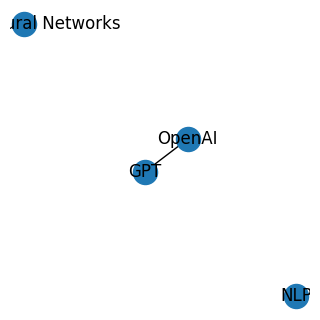

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(3,3))
pos=nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)
plt.show()

# Implementing the Graph-Based Retriever

 - Use Node2Vec to generate embeddings for each node in the graph.
 - Create an embedding matrix and a mapping from node names to indices.
 - Build the Faiss Index
 - Implement the Custom Retriever

### Details about the parameters selected for node2vec

### Understanding Node2Vec Parameters

**Node2Vec** is an algorithm designed to learn continuous feature representations for nodes in a graph by simulating biased random walks and then applying the Skip-Gram model from **word2vec**. The main idea is to capture the network's topology and structure in the embeddings.

#### Parameters in `Node2Vec` Constructor

##### `dimensions=64`

- **What it is**: Specifies the size of the embedding vectors (i.e., the number of features in the embedding space).
- **Why 64**: A dimension of 64 is a common default that balances embedding quality and computational efficiency.
- **Other possible values**: Typical values are 32, 64, 128, or 256.
- **Criteria for choosing**:
  - **Graph Complexity**: More complex graphs may benefit from higher-dimensional embeddings to capture intricate relationships.
  - **Computational Resources**: Higher dimensions increase memory usage and computation time.
  - **Downstream Tasks**: If your application (e.g., node classification, link prediction) requires capturing subtle differences between nodes, higher dimensions may be beneficial.

##### `walk_length=20`

- **What it is**: The number of nodes visited during each random walk.
- **Why 20**: A walk length of 20 allows the random walk to capture both local and some global structures in the graph.
- **Other possible values**: Values can range from 10 to 80 or more.
- **Criteria for choosing**:
  - **Graph Diameter**: If the graph has a large diameter (nodes are far apart), longer walks can capture more global information.
  - **Local vs. Global Structure**: Shorter walks focus on local neighborhoods; longer walks include more distant nodes.
  - **Performance**: Longer walks increase computation time and memory usage.

##### `num_walks=100`

- **What it is**: The number of walks to start from each node.
- **Why 100**: Starting 100 walks from each node ensures a good coverage of the graph's structure.
- **Other possible values**: Commonly range from 10 to several hundred.
- **Criteria for choosing**:
  - **Graph Size**: Larger graphs may require more walks to adequately sample the space.
  - **Variance Reduction**: More walks can reduce variance in the embeddings.
  - **Computation Time**: Increasing the number of walks increases computation time proportionally.

##### `workers=4`

- **What it is**: The number of parallel threads used for computation.
- **Why 4**: Likely corresponds to the number of CPU cores available, allowing efficient parallel processing.
- **Other possible values**: Any positive integer up to the number of CPU cores.
- **Criteria for choosing**:
  - **Hardware Availability**: Use the number of cores available to maximize performance.
  - **System Load**: Be mindful of other processes; over-allocating can lead to system slowdowns.

---

#### Parameters in `model.fit` Method

The `fit` method applies the Skip-Gram model to the generated random walks to learn embeddings.

##### `window=10`

- **What it is**: The maximum distance between the current node and predicted nodes within a random walk.
- **Why 10**: A larger window size captures broader context from each random walk.
- **Other possible values**: Typically between 2 and 10, but can be larger.
- **Criteria for choosing**:
  - **Contextual Information**: Larger windows consider more nodes as context, potentially capturing more structural information.
  - **Computational Cost**: Larger windows increase the number of training examples, impacting training time.

##### `min_count=1`

- **What it is**: Ignores all nodes with total frequency lower than this threshold during training.
- **Why 1**: Setting it to 1 ensures that all nodes are included in the training, even those that appear infrequently.
- **Other possible values**: Values greater than 1 can exclude rare nodes.
- **Criteria for choosing**:
  - **Data Sparsity**: If some nodes are extremely rare and potentially noisy, increasing `min_count` can improve embedding quality.
  - **Graph Coverage**: Setting `min_count` too high may exclude important nodes.

##### `batch_words=4`

- **What it is**: The target size (in words) for batches of examples passed to worker threads.
- **Why 4**: A small batch size can be suitable for systems with limited memory or for smaller datasets.
- **Other possible values**: Commonly set to 10,000 or larger.
- **Criteria for choosing**:
  - **Memory Constraints**: Larger batch sizes require more memory.
  - **Training Efficiency**: Larger batches can improve computational efficiency due to vectorization.
  - **Convergence Stability**: Smaller batches can provide more stable updates but may take longer to converge.

---

#### Practical Tips

- **Start with Default Values**: If you're unsure, begin with commonly used defaults and adjust from there.
- **Monitor Training**: Keep an eye on training time and resource usage; adjust parameters if training takes too long or uses too much memory.
- **Visualize Embeddings**: Use dimensionality reduction techniques (e.g., t-SNE, UMAP) to visualize embeddings and assess their quality.
- **Validate on Downstream Tasks**: Evaluate how well the embeddings perform on tasks like node classification to guide parameter selection.


In [9]:
from node2vec import Node2Vec
node2vec=Node2Vec(G, dimensions=64, walk_length=20, num_walks=100, workers=4)
n2v_model=node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities:   0%|          | 0/4 [00:00<?, ?it/s]

In [11]:
node2idx={node:idx for idx, node in enumerate(G.nodes())}
idx2node={idx:node for node, idx in node2idx.items()}

#create embeddings
embeddings_dim=n2v_model.vector_size
embedding_matrix=np.zeros((len(G.nodes()), embeddings_dim))
for idx, node in idx2node.items():
  embedding_matrix[idx]=n2v_model.wv[node]


- **IndexFlatL2** is a type of index in Faiss that stores all vectors in their raw form and performs exact nearest neighbor searches. One can also use IndexHNSW

---

- **Flat** means the index does not use any compression or approximation; it computes exact distances, which can be computationally intensive for large datasets.


In [12]:


#build faiss index
index=faiss.IndexFlatL2(embeddings_dim)
index.add(embedding_matrix)


### Implement the Custom Retriever that uses the graph embeddings.

In [13]:
from langchain.schema import Document
class GraphRetriever(BaseRetriever):
  def __init__(self, nlp, index, n2v_model, node2index, processed_docs):
        self.nlp = nlp
        self.index = index
        self.n2v_model = n2v_model
        self.node2index = node2index
        self.processed_docs = processed_docs
  def aget_relevant_documents(self): pass
  def get_relevant_documents(self, query)->List[str]:
    query_doc=self.nlp(query)
    query_entities = [ent.text for ent in query_doc.ents if ent.text in self.n2v_model.wv]
    if not query_entities:
            return []
    query_embeddings=np.array([self.n2v_model.wv[ent] for ent in query_entities]).astype('float32')
    avg_query_embedding = np.mean(query_embeddings, axis=0).reshape(1, -1)
    # Search in the index
    k = 5  # Number of nearest neighbors
    distances, indices = self.index.search(avg_query_embedding, k)
    retrieved_nodes = [idx2node[idx] for idx in indices[0] if idx != -1]

    # Retrieve documents containing these nodes
    relevent_docs=[]
    # print(f"in retriever class : {retrieved_nodes}")
    for node in retrieved_nodes:
      for doc in self.processed_docs:
        # print(f"doc: {doc}. , node={node}" )
        if node in [ent[0] for ent in doc['entities']]:
            document = Document(
                        page_content=doc['text'],
                        metadata={'source_node': node}
                    )
            relevent_docs.append(document)
    # Remove duplicates
    # print(f"in retriver class relevent_docs:{relevent_docs}")
    unique_docs = {doc.page_content: doc for doc in relevent_docs}

    return list(unique_docs.values())



# Integrating with the Language Model

In [ ]:
## Initialize the Language Model
## Create the RetrievalQA Chain
## Customize the Prompt Template (Optional)

In [14]:
import openai
from langchain.llms import OpenAI
retriever = GraphRetriever(
    nlp=nlp,
    index=index,
    n2v_model=n2v_model,
    node2index=node2idx,
    processed_docs=processed_docs
)
# qa_chain = RetrievalQA(llm=llm, retriever=retriever)

In [18]:
from langchain.chains import RetrievalQA
os.environ["OPENAI_API_KEY"]="YOUR OPENAI KEY"
llm = OpenAI(temperature=0.7, model_name="gpt-3.5-turbo")

qa_chain = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff",retriever=retriever)

/usr/local/lib/python3.10/dist-packages/langchain/llms/openai.py:179: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/langchain/llms/openai.py:751: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`
  warnings.warn(


In [19]:
# Define a custom prompt template
prompt_template = PromptTemplate(
    input_variables=["context", "question"],
    template="""
    Use the following context to answer the question.

    Context:
    {context}

    Question:
    {question}

    Answer:"""
)

qa_chain.combine_documents_chain.llm_chain.prompt = prompt_template


# Testing the System

In [20]:
query = "How are transformers used in NLP?"
answer = qa_chain.run(query)
print("Question:", query)
print("\nAnswer:", answer)


Question: How are transformers used in NLP?

Answer: Transformers are used in NLP tasks to analyze and process textual data by capturing long-range dependencies and relationships between words in a sentence. Transformers have been successful in various NLP applications such as language translation, text summarization, and sentiment analysis.


In [21]:
query = "How are transformers used in NLP?"
retrieved_docs = retriever.get_relevant_documents(query)
print("\nRetrieved Documents:" , retrieved_docs)
for idx, doc in enumerate(retrieved_docs):
    print(f"\nDocument {idx+1}:\n{doc}")



Retrieved Documents: [Document(page_content='Transformers are a type of neural network architecture that have been used for NLP tasks.', metadata={'source_node': 'NLP'}), Document(page_content='Graph Neural Networks can capture dependencies in graph-structured data.', metadata={'source_node': 'Graph Neural Networks'}), Document(page_content='The GPT models are developed by OpenAI and are used for text generation.', metadata={'source_node': 'OpenAI'})]

Document 1:
page_content='Transformers are a type of neural network architecture that have been used for NLP tasks.' metadata={'source_node': 'NLP'}

Document 2:
page_content='Graph Neural Networks can capture dependencies in graph-structured data.' metadata={'source_node': 'Graph Neural Networks'}

Document 3:
page_content='The GPT models are developed by OpenAI and are used for text generation.' metadata={'source_node': 'OpenAI'}
